<a href="https://colab.research.google.com/github/saitharun5515/Dissertation-Early-Detection-of-Alzheimer-s-Disease-/blob/main/Alzheimers_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("Falah/Alzheimer_MRI")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5120
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1280
    })
})

In [ ]:
label_names = {
    0: "MildDemented",
    1: "ModerateDemented",
    2: "NonDemented",
    3: "VeryMildDemented"
}

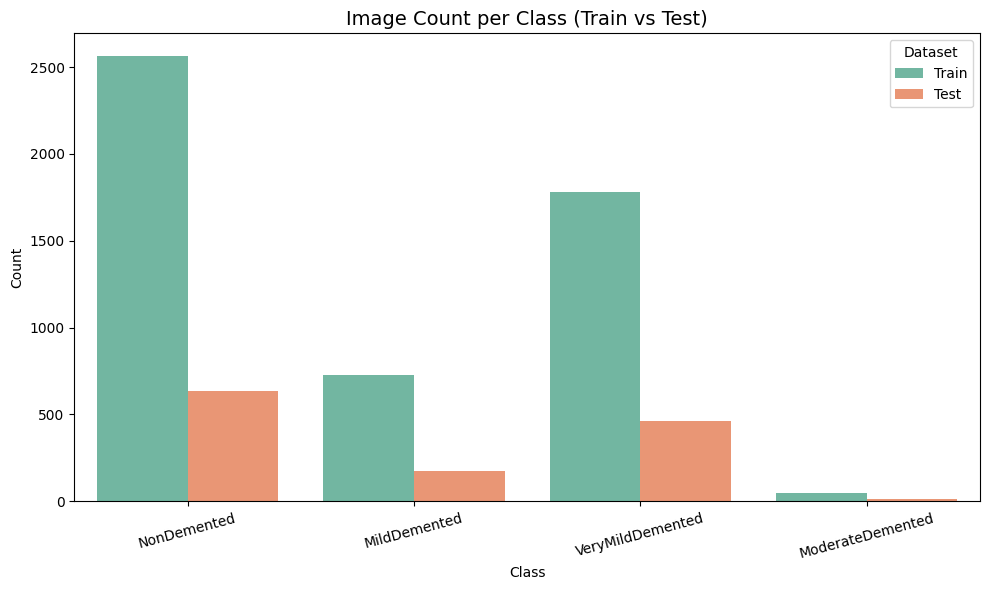

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

train_counts = Counter(dataset['train']['label'])
test_counts = Counter(dataset['test']['label'])


df_train = pd.DataFrame({'Class': [label_names[i] for i in train_counts.keys()],
                         'Count': train_counts.values(),
                         'Dataset': 'Train'})

df_test = pd.DataFrame({'Class': [label_names[i] for i in test_counts.keys()],
                        'Count': test_counts.values(),
                        'Dataset': 'Test'})

df_all = pd.concat([df_train, df_test])

plt.figure(figsize=(10,6))
sns.barplot(x='Class', y='Count', hue='Dataset', data=df_all, palette='Set2')
plt.title("Image Count per Class (Train vs Test)", fontsize=14)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

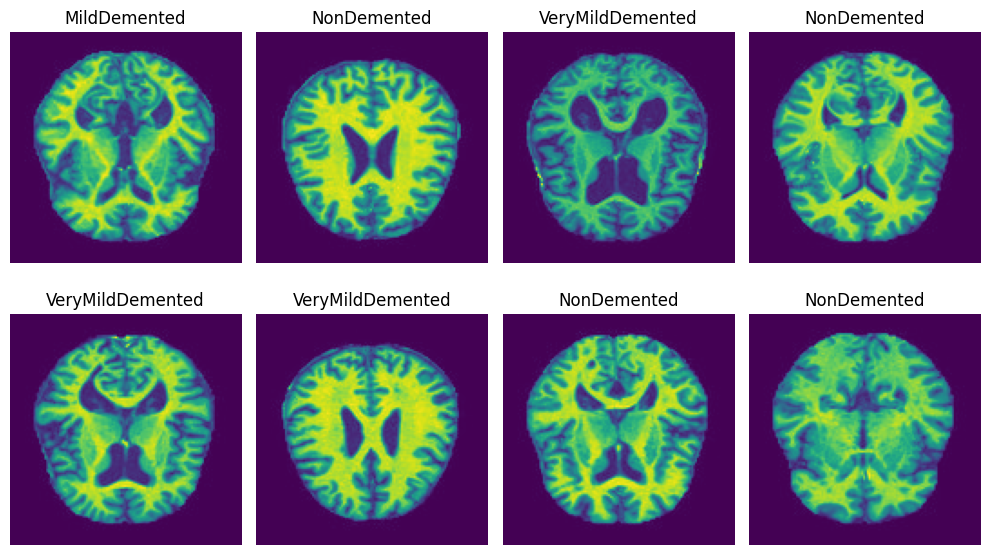

In [ ]:
import random

plt.figure(figsize=(10,6))
for i in range(8):
    sample = random.choice(dataset['train'])
    img = sample['image']
    label = label_names[sample['label']]
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#
train_valid_split = dataset['train'].train_test_split(test_size=0.10, seed=42)
train_hf = train_valid_split['train']
val_hf   = train_valid_split['test']
test_hf  = dataset['test']

print("HF sizes -> train:", len(train_hf), "val:", len(val_hf), "test:", len(test_hf))

print("Train counts:", Counter(train_hf['label']))
print("Val counts:  ", Counter(val_hf['label']))
print("Test counts: ", Counter(test_hf['label']))

HF sizes -> train: 4608 val: 512 test: 1280
Train counts: Counter({2: 2313, 3: 1612, 0: 644, 1: 39})
Val counts:   Counter({2: 253, 3: 169, 0: 80, 1: 10})
Test counts:  Counter({2: 634, 3: 459, 0: 172, 1: 15})


In [ ]:
#defines a class HFDatasetTorch, which wraps a Hugging Face dataset so it can be used with PyTorch’s DataLoader.

from torch.utils.data import Dataset

class HFDatasetTorch(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item['image']

        if hasattr(img, "mode"):
            if img.mode != "RGB":
                img = img.convert("RGB")
        else:

            from PIL import Image
            img = Image.fromarray(img).convert("RGB")

        label = int(item['label'])
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
from datasets import load_dataset
import numpy as np
from PIL import Image
import random
from collections import Counter
import time
import copy

In [ ]:
#data augmentation- give varied versions of image  for models
import torchvision.transforms as T

IMG_SIZE = 224
train_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_test_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [ ]:
#prepares data so that it can be efficiently used by deep learning model for test, train, and validation.
BATCH_SIZE = 32
num_workers = 2
train_ds = HFDatasetTorch(train_hf, transform=train_transforms)
val_ds   = HFDatasetTorch(val_hf, transform=val_test_transforms)
test_ds  = HFDatasetTorch(test_hf, transform=val_test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [ ]:
# to check dataloader working properly before giving to model.
batch = next(iter(train_loader))
imgs, labels = batch
print("Images shape:", imgs.shape)
print("Labels shape:", labels.shape)

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
